<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/Stock_NeurIPS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [146]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools



In [147]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.4'></a>
## 2.4. Create Folders

In [148]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [149]:
print(dir(config_tickers))
print(config_tickers.SINGLE_TICKER)

['CAC_40_TICKER', 'CSI_300_TICKER', 'DAX_30_TICKER', 'DOW_30_TICKER', 'FX_TICKER', 'HSI_50_TICKER', 'LQ45_TICKER', 'MDAX_50_TICKER', 'NAS_100_TICKER', 'SDAX_50_TICKER', 'SINGLE_TICKER', 'SP_500_TICKER', 'SRI_KEHATI_TICKER', 'SSE_50_TICKER', 'TECDAX_TICKER', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'annotations']
['^DJI']


In [150]:
TRAIN_START_DATE, TEST_START_DATE, TRADE_START_DATE

('2014-01-06', '2020-08-01', '2021-11-01')

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [151]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [152]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-31'


In [153]:
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
config_tickers.SINGLE_TICKER=['^DJI']
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.SINGLE_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3230, 8)


In [154]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [155]:
df.shape

(3230, 8)

In [156]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,8772.250000,9065.280273,8760.780273,9034.690430,213700000,^DJI,4
1,2009-01-05,9027.129883,9034.370117,8892.360352,8952.889648,233760000,^DJI,0
2,2009-01-06,8954.570312,9088.059570,8940.950195,9015.099609,215410000,^DJI,1
3,2009-01-07,8996.940430,8996.940430,8719.919922,8769.700195,266710000,^DJI,2
4,2009-01-08,8769.940430,8770.019531,8651.190430,8742.459961,226620000,^DJI,3


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [157]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [158]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)


In [159]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,^DJI,8772.250000,9065.280273,8760.780273,9034.690430,213700000.0,4.0,0.000000,9109.473813,8878.106265,0.000000,66.666667,100.000000,9034.690430,9034.690430,39.189999,0.0
1,2009-01-05,^DJI,9027.129883,9034.370117,8892.360352,8952.889648,233760000.0,0.0,-1.835274,9109.473813,8878.106265,0.000000,66.666667,100.000000,8993.790039,8993.790039,39.080002,0.0
2,2009-01-06,^DJI,8954.570312,9088.059570,8940.950195,9015.099609,215410000.0,1.0,-0.409376,9086.314723,8915.471736,44.031836,100.000000,100.000000,9000.893229,9000.893229,38.560001,0.0
3,2009-01-07,^DJI,8996.940430,8996.940430,8719.919922,8769.700195,266710000.0,2.0,-8.610869,9184.579490,8701.610451,15.743557,-133.333333,62.968091,8943.094971,8943.094971,43.389999,0.0
4,2009-01-08,^DJI,8769.940430,8770.019531,8651.190430,8742.459961,226620000.0,3.0,-13.970109,9178.539385,8627.396552,14.661898,-120.516235,70.860502,8902.967969,8902.967969,42.560001,0.0
5,2009-01-09,^DJI,8738.799805,8769.620117,8576.959961,8599.179688,204300000.0,4.0,-23.055896,9202.017249,8502.655928,10.672198,-112.890980,76.614642,8852.336589,8852.336589,42.820000,0.0
6,2009-01-12,^DJI,8599.259766,8602.599609,8421.080078,8473.969727,273550000.0,0.0,-34.157792,9226.890874,8369.677486,8.565203,-131.057765,83.796980,8798.284180,8798.284180,45.840000,0.0
7,2009-01-13,^DJI,8474.610352,8522.080078,8376.879883,8448.559570,304050000.0,1.0,-42.261245,9222.130326,8287.006881,8.224323,-114.994135,85.176914,8754.568604,8754.568604,43.270000,0.0
8,2009-01-14,^DJI,8446.009766,8446.250000,8140.720215,8200.139648,355050000.0,2.0,-59.554727,9265.595850,8120.334923,5.864044,-138.445455,90.027631,8692.965386,8692.965386,49.139999,0.0
9,2009-01-15,^DJI,8196.240234,8286.160156,7995.129883,8212.490234,436660000.0,3.0,-70.319635,9264.445300,8025.390442,7.233284,-131.911273,91.796705,8644.917871,8644.917871,51.000000,0.0


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [160]:
TRAIN_START_DATE, TRAIN_END_DATE, TRADE_START_DATE, TRADE_END_DATE

('2009-01-01', '2020-07-01', '2020-07-01', '2021-10-31')

In [161]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2893
336


In [164]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2888,2020-06-24,^DJI,25992.960938,25992.960938,25296.730469,25445.939453,450120000.0,2.0,297.499225,27457.819115,24740.567018,51.165844,6.669873,5.834088,25513.512630,24461.826595,33.840000,1.480291
2889,2020-06-25,^DJI,25365.220703,25769.609375,25209.789062,25745.599609,384560000.0,3.0,259.220121,27446.178663,24786.703369,52.329446,0.380265,7.348562,25596.766927,24525.633919,32.220001,0.269551
2890,2020-06-26,^DJI,25641.689453,25641.689453,24971.029297,25015.550781,640860000.0,4.0,168.037780,27479.625096,24716.501076,49.364983,-40.685028,11.525743,25643.107292,24593.501270,34.730000,1.599579
2891,2020-06-29,^DJI,25152.449219,25601.150391,25096.160156,25595.800781,378070000.0,0.0,140.971414,27475.213437,24732.990860,51.618524,-27.315506,11.525743,25706.786654,24663.207292,31.780001,1.051319
2892,2020-06-30,^DJI,25512.429688,25905.380859,25475.140625,25812.880859,410780000.0,1.0,135.475988,27475.182405,24740.044939,52.437753,-0.605641,4.655649,25747.303711,24742.546484,30.430000,0.136805


In [163]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,^DJI,25879.380859,26019.310547,25713.609375,25734.970703,373180000.0,2.0,123.411515,27455.975874,24705.759477,52.110151,4.254472,2.136994,25798.240755,24793.462826,28.620001,0.019215
1,2020-07-02,^DJI,25936.449219,26204.410156,25778.119141,25827.359375,349130000.0,3.0,119.922929,27434.290269,24681.998989,52.474383,12.938943,1.960689,25839.956055,24846.354492,27.680000,0.023754
2,2020-07-06,^DJI,25996.080078,26297.529297,25996.080078,26287.029297,340690000.0,0.0,152.491889,27307.024181,24726.869960,54.264723,39.902249,4.031223,25900.386393,24893.912142,27.940001,0.611578
3,2020-07-07,^DJI,26172.009766,26174.929688,25866.580078,25890.179688,346820000.0,1.0,144.613563,26995.148688,24870.519476,52.498452,5.331023,0.864465,25947.887044,24930.092318,29.430000,0.452970
4,2020-07-08,^DJI,25950.060547,26109.490234,25816.250000,26067.279297,337300000.0,2.0,150.920671,26732.415816,25012.750200,53.201662,3.641469,0.395194,25983.626042,24974.700814,28.080000,0.087673


In [165]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [166]:
stock_dimension = len(train.tic.unique())
#2stock dimension: price plus holding for each stock
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 11


In [167]:
#make costs larger
base_cost = 0.005

buy_cost_list = sell_cost_list = [base_cost] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)


In [168]:
print(sell_cost_list)
print(num_stock_shares)
dir(StockTradingEnv)

[0.005]
[0]


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_buy_stock',
 '_get_date',
 '_initiate_state',
 '_make_plot',
 '_seed',
 '_sell_stock',
 '_update_state',
 'action_space',
 'close',
 'get_sb_env',
 'metadata',
 'observation_space',
 'render',
 'reset',
 'reward_range',
 'save_action_memory',
 'save_asset_memory',
 'save_state_memory',
 'seed',
 'spec',
 'step',
 'unwrapped']

## Environment for Training



In [313]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
dir(env_train)

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_get_indices',
 '_get_target_envs',
 '_obs_from_buf',
 '_save_obs',
 'action_space',
 'actions',
 'buf_dones',
 'buf_infos',
 'buf_obs',
 'buf_rews',
 'close',
 'env_is_wrapped',
 'env_method',
 'envs',
 'get_attr',
 'get_images',
 'getattr_depth_check',
 'keys',
 'metadata',
 'num_envs',
 'observation_space',
 'render',
 'reset',
 'seed',
 'set_attr',
 'step',
 'step_async',
 'step_wait',
 'unwrapped']

In [170]:
env_train.metadata

{'render.modes': ['human']}

<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [314]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True


In [172]:
dir(DRLAgent)

['DRL_prediction',
 'DRL_prediction_load_from_file',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'get_model',
 'train_model']

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [315]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [174]:
print(dir(model_a2c))
model_a2c.action_space
model_a2c.observation_space

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_current_progress_remaining', '_custom_logger', '_episode_num', '_excluded_save_params', '_get_eval_env', '_get_policy_from_name', '_get_torch_save_params', '_init_callback', '_last_episode_starts', '_last_obs', '_last_original_obs', '_logger', '_n_updates', '_num_timesteps_at_start', '_setup_learn', '_setup_lr_schedule', '_setup_model', '_total_timesteps', '_update_current_progress_remaining', '_update_info_buffer', '_update_learning_rate', '_vec_normalize_env', '_wrap_env', 'action_noise', 'action_space', 'collect_rollouts', 'device', 'ent_coef', 'env', 'ep_info_buffer', 'ep_su

Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf], (11,), float32)

In [316]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

------------------------------------
| time/                 |          |
|    fps                | 594      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0378   |
|    reward             | 0.0      |
|    std                | 1.01     |
|    value_loss         | 0.000929 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 628      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|

### Agent 2: DDPG

In [185]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [186]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 109       |
|    time_elapsed    | 105       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | -2.32e+03 |
|    critic_loss     | 9.57e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 0.0       |
----------------------------------
day: 2892, episode: 90
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 93       |
|    time_elapsed    | 248      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | -611     |
|    critic_loss     | 387      |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward          | 0.0      |
----

### Agent 3: PPO

In [187]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/a2c


In [188]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

-----------------------------
| time/              |      |
|    fps             | 754  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
| train/             |      |
|    reward          | 0.0  |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 718           |
|    iterations           | 2             |
|    time_elapsed         | 5             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.005757153   |
|    clip_fraction        | 0.0477        |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.00901       |
|    learning_rate        | 0.00025       |
|    loss                 | 0.434         |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00384      |
|    reward               

### Agent 4: TD3

In [189]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [190]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000) if if_using_td3 else None

day: 2892, episode: 120
begin_total_asset: 1000000.00
end_total_asset: 445769.21
total_reward: -554230.79
total_cost: 75547.71
total_trades: 86
Sharpe: -0.352
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 97       |
|    time_elapsed    | 118      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 4.66e+04 |
|    critic_loss     | 3.13e+06 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 86       |
|    time_elapsed    | 268      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 3.78e+04 |
|    critic_loss     | 1.32e+06 |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward          | 0.

### Agent 5: SAC

In [191]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [192]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name
                                ='sac',
                             total_timesteps=40000) if if_using_sac else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 68       |
|    time_elapsed    | 169      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 9.73e+03 |
|    critic_loss     | 4.2e+04  |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | 11       |
|    learning_rate   | 0.0001   |
|    n_updates       | 11471    |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 70       |
|    time_elapsed    | 326      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 5.94e+03 |
|    critic_loss     | 4.58e+05 |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.01    |
|    learning_rate   | 0.0001   |
|    n_updates       | 23043    |
|    reward          | 0.0      |
--------------

## In-sample Performance

Assume that the initial capital is $1,000,000.

In [312]:
dir(trained_a2c.env)
trained_a2c.env

In [193]:
dir(trained_a2c)
#trained_a2c.policy
#trained_a2c.env


['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_current_progress_remaining',
 '_custom_logger',
 '_episode_num',
 '_excluded_save_params',
 '_get_eval_env',
 '_get_policy_from_name',
 '_get_torch_save_params',
 '_init_callback',
 '_last_episode_starts',
 '_last_obs',
 '_last_original_obs',
 '_logger',
 '_n_updates',
 '_num_timesteps_at_start',
 '_setup_learn',
 '_setup_lr_schedule',
 '_setup_model',
 '_total_timesteps',
 '_update_current_progress_remaining',
 '_update_info_buffer',
 '_update_learning_rate',
 '_vec_normalize_env',
 '_wrap_env',
 'action_noise',
 'action_space',
 'collect_rollouts'

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [194]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [195]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [196]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [197]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean        1.164279
std         4.174879
min         0.000000
25%         0.020504
50%         0.192936
75%         0.932900
max       101.217769
Name: turbulence, dtype: float64

In [198]:
insample_risk_indicator.turbulence.quantile(0.996)

27.871858062139864

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [199]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [200]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,^DJI,25879.380859,26019.310547,25713.609375,25734.970703,373180000.0,2.0,123.411515,27455.975874,24705.759477,52.110151,4.254472,2.136994,25798.240755,24793.462826,28.620001,0.019215
1,2020-07-02,^DJI,25936.449219,26204.410156,25778.119141,25827.359375,349130000.0,3.0,119.922929,27434.290269,24681.998989,52.474383,12.938943,1.960689,25839.956055,24846.354492,27.680000,0.023754
2,2020-07-06,^DJI,25996.080078,26297.529297,25996.080078,26287.029297,340690000.0,0.0,152.491889,27307.024181,24726.869960,54.264723,39.902249,4.031223,25900.386393,24893.912142,27.940001,0.611578
3,2020-07-07,^DJI,26172.009766,26174.929688,25866.580078,25890.179688,346820000.0,1.0,144.613563,26995.148688,24870.519476,52.498452,5.331023,0.864465,25947.887044,24930.092318,29.430000,0.452970
4,2020-07-08,^DJI,25950.060547,26109.490234,25816.250000,26067.279297,337300000.0,2.0,150.920671,26732.415816,25012.750200,53.201662,3.641469,0.395194,25983.626042,24974.700814,28.080000,0.087673


In [209]:
trained_model = trained_a2c
#trained_model = trained_ddpg
#trained_model = trained_ppo
#trained_model = trained_td3
#trained_model = trained_sac

df_account_value_insample, df_actions_insample = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_train_gym)

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!
hit end!


In [210]:
print("Shape:", df_account_value.shape)
print("In Sample End Value    :", df_account_value_insample.tail(1))
print("Out of Sample End Value:", df_account_value.tail(1))

Shape: (336, 2)
In Sample End Value    :             date  account_value
2892  2020-06-30   2.841454e+06
Out of Sample End Value:            date  account_value
335  2021-10-28   1.374940e+06


In [211]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.372908e+06
332,2021-10-25,1.375345e+06
333,2021-10-26,1.375943e+06
334,2021-10-27,1.365828e+06
335,2021-10-28,1.374940e+06


In [220]:
print(df_actions.head())
print(df_actions.tail())

         date actions
0  2020-07-01    [38]
1  2020-07-02     [0]
2  2020-07-06     [0]
3  2020-07-07     [0]
4  2020-07-08     [0]
           date actions
330  2021-10-21     [0]
331  2021-10-22     [0]
332  2021-10-25     [0]
333  2021-10-26     [0]
334  2021-10-27     [0]


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [213]:
backtest_stats

<function finrl.plot.backtest_stats(account_value, value_col_name='account_value')>

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [214]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_insample = backtest_stats(account_value=df_account_value_insample)
perf_stats_insample = pd.DataFrame(perf_stats_insample)

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.095233
Cumulative returns     1.841454
Annual volatility      0.180906
Sharpe ratio           0.593912
Calmar ratio           0.256949
Stability              0.958657
Max drawdown          -0.370629
Omega ratio            1.126237
Sortino ratio          0.829224
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936981
Daily value at risk   -0.022366
dtype: float64
Annual return          0.269734
Cumulative returns     0.374940
Annual volatility      0.137064
Sharpe ratio           1.816747
Calmar ratio           3.067202
Stability              0.918800
Max drawdown          -0.087941
Omega ratio            1.352879
Sortino ratio          2.693034
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.053819
Daily value at risk   -0.016280
dtype: float64


In [215]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df_insample = get_baseline(
        ticker="^DJI", 
        start = df_account_value_insample.loc[0,'date'],
        end = df_account_value_insample.loc[len(df_account_value_insample)-1,'date'])

stats_insample = backtest_stats(baseline_df_insample, value_col_name = 'close')


baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2892, 8)
Annual return          0.094985
Cumulative returns     1.833058
Annual volatility      0.181133
Sharpe ratio           0.592146
Calmar ratio           0.256120
Stability              0.958640
Max drawdown          -0.370862
Omega ratio            1.125864
Sortino ratio          0.826817
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936271
Daily value at risk   -0.022395
dtype: float64
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtos

In [216]:
df_account_value.loc[0,'date']

'2020-07-01'

In [217]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2892, 8)


Start date,2009-01-02
End date,2020-06-30
Total months,137
,Backtest
Annual return,9.523%
Cumulative returns,184.145%
Annual volatility,18.091%
Sharpe ratio,0.59
Calmar ratio,0.26
Stability,0.96
Max drawdown,-37.063%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.06,2020-02-12,2020-03-23,NaT,NaN
1,27.78,2009-01-02,2009-03-09,2009-07-24,146
2,18.76,2018-10-03,2018-12-24,2019-07-03,196
3,16.80,2011-04-29,2011-10-03,2012-02-03,201
4,14.47,2015-05-19,2016-02-11,2016-07-12,301


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.03%,-5.54%,3.97%
Fukushima,0.18%,-2.04%,1.50%
EZB IR Event,0.01%,-0.95%,1.55%
2009Q1,-0.64%,-4.61%,3.50%
2009Q2,0.35%,-4.23%,6.82%
Flash Crash,-0.29%,-3.18%,3.89%
Apr14,0.03%,-1.62%,1.11%
Oct14,0.09%,-1.97%,1.64%
Fall2015,-0.21%,-3.57%,3.95%
GFC Crash,-0.23%,-4.61%,6.82%


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,26.973%
Cumulative returns,37.494%
Annual volatility,13.706%
Sharpe ratio,1.82
Calmar ratio,3.07
Stability,0.92
Max drawdown,-8.794%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.79,2020-09-02,2020-10-30,2020-11-09,49
1,4.94,2021-08-16,2021-09-30,2021-10-22,50
2,4.22,2021-05-07,2021-06-18,2021-07-02,41
3,3.81,2021-01-20,2021-01-29,2021-02-08,14
4,3.20,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.10%,-3.38%,2.90%


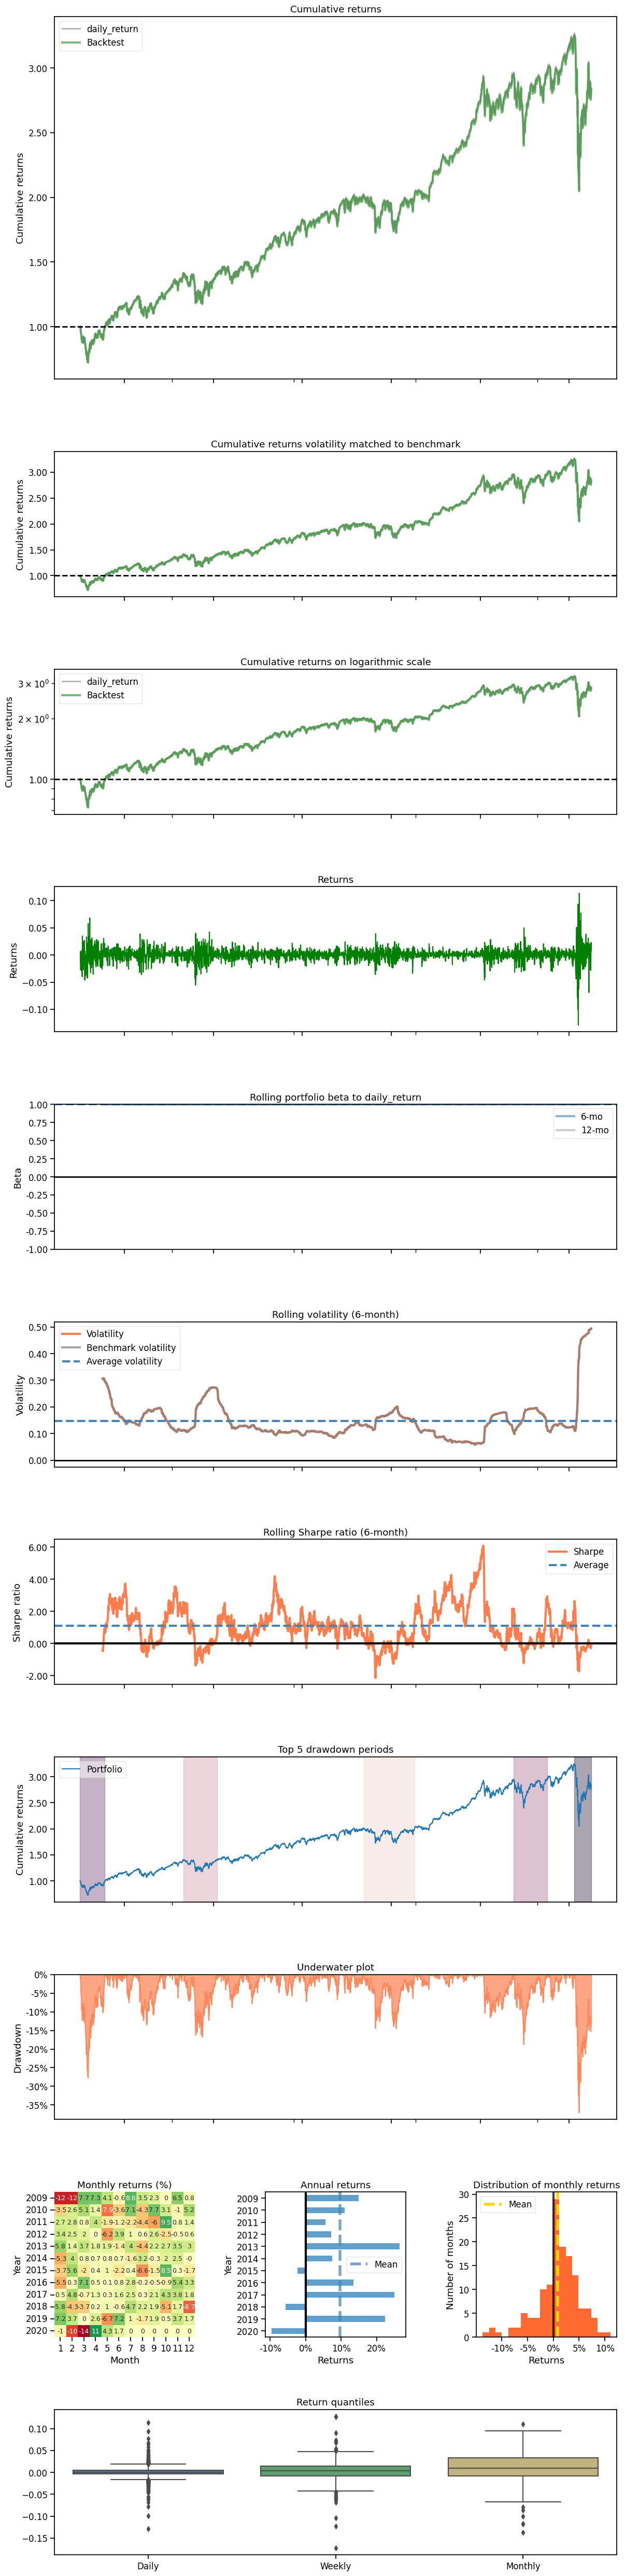

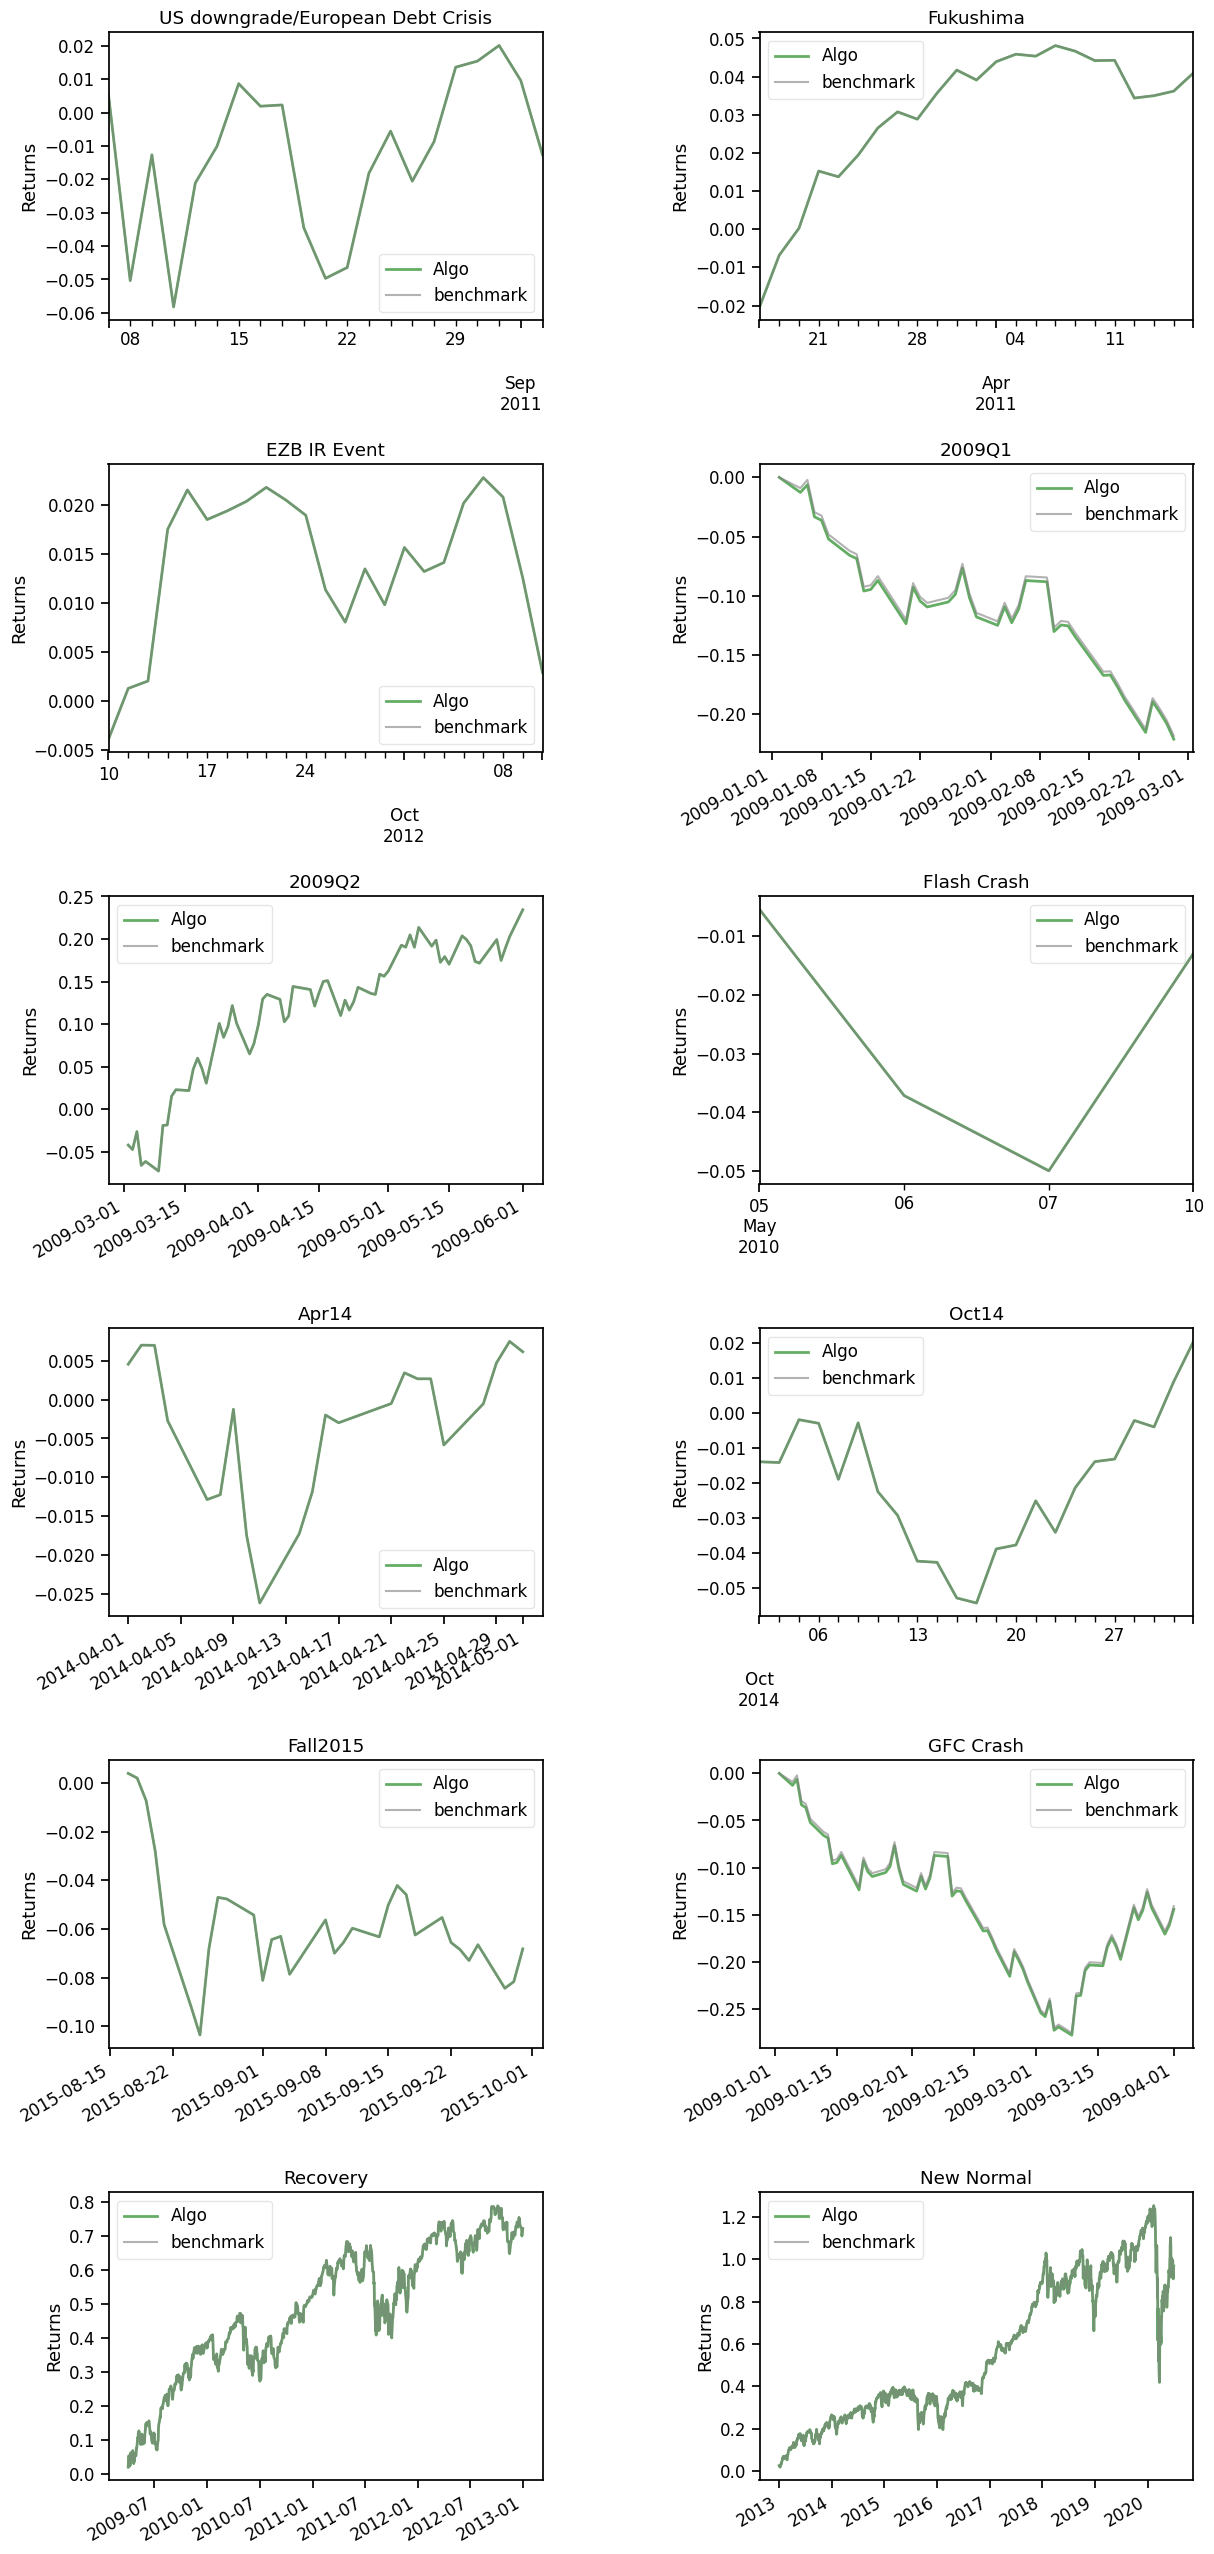

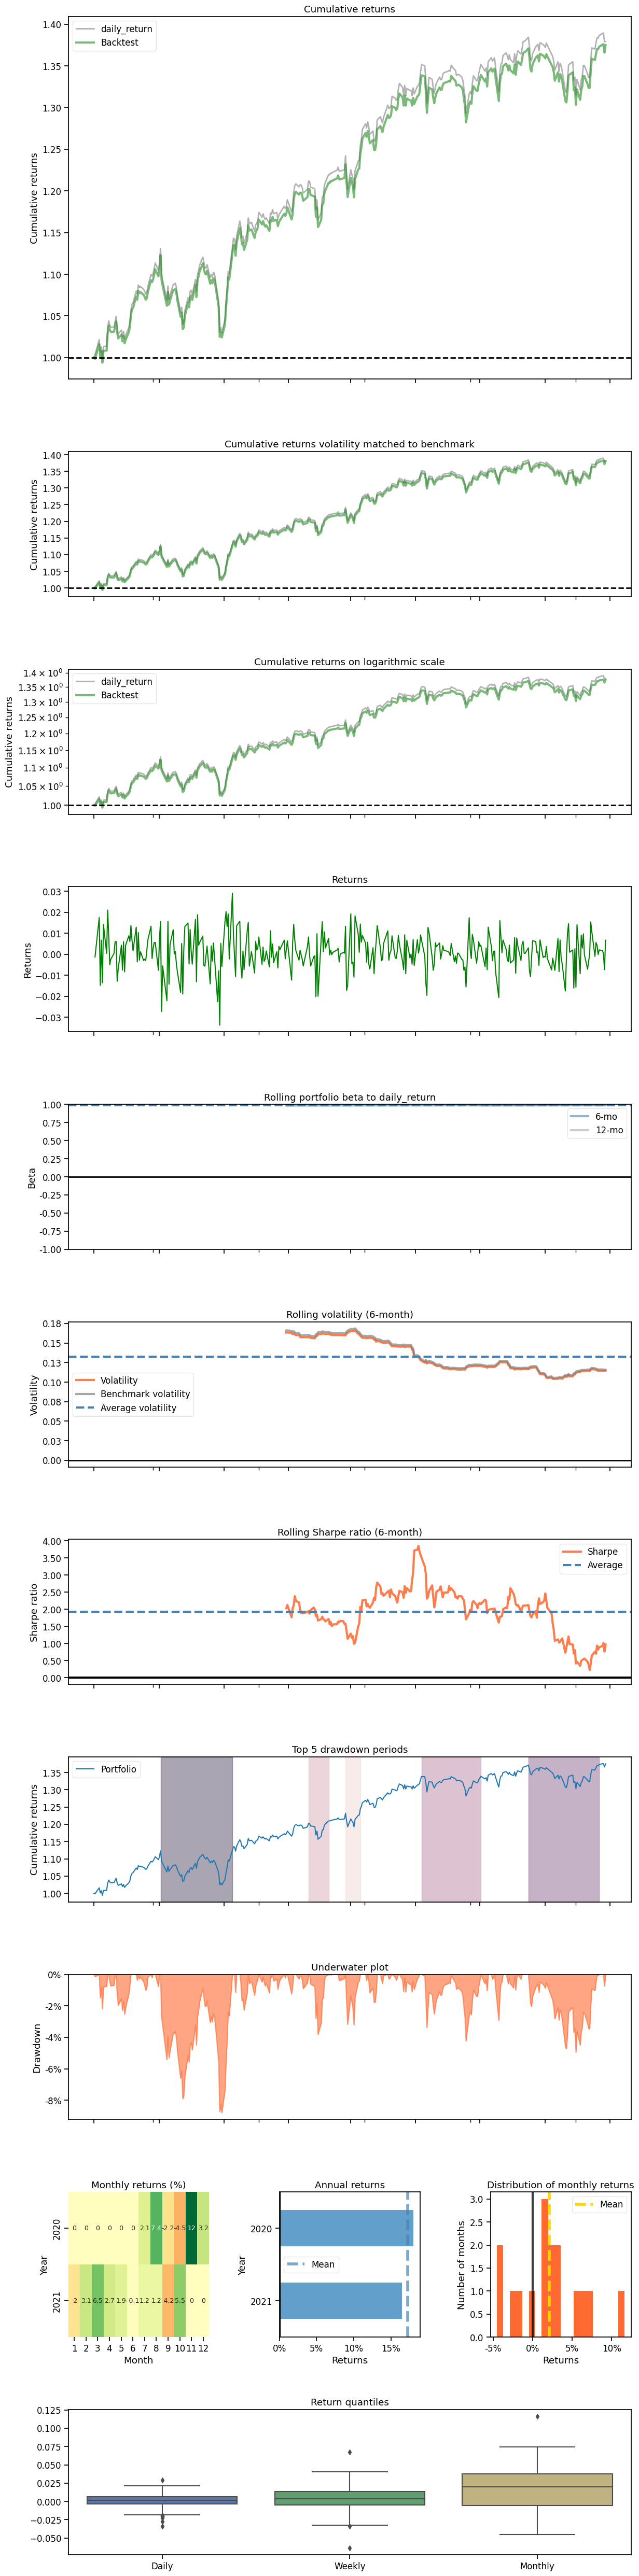

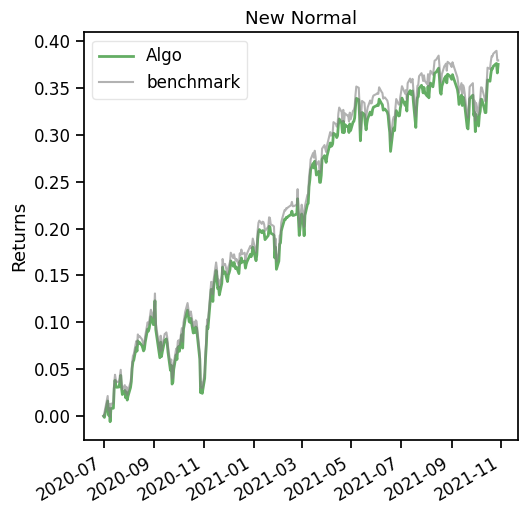

In [219]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_insample, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_insample.loc[0,'date'],
             baseline_end = df_account_value_insample.loc[len(df_account_value_insample)-1,'date'])


backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [221]:
### looking at hyperparam optimisation

agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)



{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [231]:
dir(model_a2c)
#model_a2c.ent_coef
#model_a2c.n_steps
#model_a2c.learning_rate
#model_a2c.verbose

#n_steps_list = [5,10,15]
#eng_coef_list = [0.01, 0.05, 0.1]
#learning_rate_list = [0.0001, 0.001, 0.005]

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_current_progress_remaining',
 '_custom_logger',
 '_episode_num',
 '_excluded_save_params',
 '_get_eval_env',
 '_get_policy_from_name',
 '_get_torch_save_params',
 '_init_callback',
 '_last_episode_starts',
 '_last_obs',
 '_last_original_obs',
 '_logger',
 '_n_updates',
 '_num_timesteps_at_start',
 '_setup_learn',
 '_setup_lr_schedule',
 '_setup_model',
 '_total_timesteps',
 '_update_current_progress_remaining',
 '_update_info_buffer',
 '_update_learning_rate',
 '_vec_normalize_env',
 '_wrap_env',
 'action_noise',
 'action_space',
 'collect_rollouts'

In [ ]:
! pip install optuna


In [253]:
#make costs larger
base_cost = 0.003

buy_cost_list = sell_cost_list = [base_cost] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)


In [254]:
#dir(e_train_gym)
#e_train_gym.print_verbosity
tmp_env_train, _ = e_train_gym.get_sb_env()

tmp_agent = DRLAgent(env = tmp_env_train)
tmp_model = tmp_agent.get_model("a2c")
tmp_model.verbose=0

#N_TRIALS = 100
#N_STARTUP_TRIALS = 5
#N_EVALUATIONS = 2
#N_TIMESTEPS = int(2e4)
#EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
#N_EVAL_EPISODES = 3

tmp_n_timesteps = 50000
tmp_deterministic=True
tmp_n_evaluations = 2

tmp_n_eval_episodes = 3
tmp_eval_freq = int(tmp_n_timesteps / tmp_n_evaluations)

tmp_trial

tmp_eval_callback = TrialEvalCallback(
        tmp_env_train, 
        tmp_trial, 
        tmp_n_eval_episodes, 
        tmp_eval_freq, 
        tmp_deterministic
    )

tmp_model.learn(tmp_n_timesteps, callback=tmp_eval_callback)
        #trained_a2c = agent.train_model(model=model_a2c, 
        #                     tb_log_name='a2c',
        #                     total_timesteps=50000)

    

10

In [295]:
#DEFAULT_HYPERPARAMS['policy']

'MlpPolicy'

In [322]:
#https://github.com/optuna/optuna-examples/blob/main/rl/sb3_simple.py
#also
#https://medium.com/analytics-vidhya/hyperparameter-tuning-using-optuna-for-finrl-8a49506d2741
""" Optuna example that optimizes the hyperparameters of
a reinforcement learning agent using A2C implementation from Stable-Baselines3
on a OpenAI Gym environment.
This is a simplified version of what can be found in https://github.com/DLR-RM/rl-baselines3-zoo.
You can run this example as follows:
    $ python sb3_simple.py
"""
from typing import Any
from typing import Dict

import gym
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
#from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
#import torch
#import torch.nn as nn


N_TRIALS = 100
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = int(2e4)
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

#learning_rate (Union[float, Callable[[float], float]]) – The learning rate, it can be a function of the current progress remaining (from 1 to 0)
#n_steps (int) – The number of steps to run for each environment per update (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
#gamma (float) – Discount factor
#gae_lambda (float) – Factor for trade-off of bias vs variance for Generalized Advantage Estimator Equivalent to classic advantage when set to 1.
#ent_coef (float) – Entropy coefficient for the loss calculation
#vf_coef (float) – Value function coefficient for the loss calculation
#max_grad_norm (float) – The maximum value for the gradient clipping



ENV_ID = "CartPole-v1"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "seed": 1234,
    "verbose": 0,    
    #"env": ENV_ID,
}

def calculate_sharpe(df):
    df['daily_return'] = df['account_value'].pct_change(1)
    if df['daily_return'].std() != 0:
        sharpe = (252**0.5)*df['daily_return'].mean()/df['daily_return'].std()
        return sharpe
    else:
        return 0


def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for A2C hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.001, 0.2, log=True)
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    #ortho_init = trial.suggest_categorical("ortho_init", [False, True])
    #net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    #activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])

    # Display true values
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("gae_lambda_", gae_lambda)
    trial.set_user_attr("n_steps", n_steps)
    trial.set_user_attr("learning_rate", learning_rate)
    trial.set_user_attr("ent_coef", ent_coef)
    trial.set_user_attr("max_grad_norm", max_grad_norm)

    #net_arch = [
    #    {"pi": [64], "vf": [64]} if net_arch == "tiny" else {"pi": [64, 64], "vf": [64, 64]}
    #]

    #activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

    return {
        "n_steps": n_steps,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "max_grad_norm": max_grad_norm,
        #"policy_kwargs": {
        #    "net_arch": net_arch,
        #    "activation_fn": activation_fn,
        #    "ortho_init": ortho_init,
        #},
    }


class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        #eval_env: gym.Env,
        #eval_env: StockTradingEnv(df = train, **env_kwargs),
        eval_env: gym.Env,
        trial: optuna.Trial,
#        n_eval_episodes: int = 5,
        n_eval_episodes: int,
#        eval_freq: int = 10000,
        eval_freq: int,
        deterministic: bool = True,
        verbose: int = 0,
    ):

        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False
        
        #print("In Trial")
        #print(dir(self))

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True


def objective(trial: optuna.Trial) -> float:

    default_kwargs = DEFAULT_HYPERPARAMS.copy()
    # Sample hyperparameters
    model_kwargs = sample_a2c_params(trial)

    # Create env used for evaluation
    #eval_env = gym.make(ENV_ID)
    eval_env, _ = e_train_gym.get_sb_env()
    
    # Create the RL model
    #model = A2C(**kwargs)

    #print(model_kwargs)
    
    agent = DRLAgent(env = eval_env)
#    model = agent.get_model("a2c", model_kwargs)
    model = agent.get_model(model_name="a2c",
                    #policy="MlpPolicy",
                    policy=default_kwargs['policy'],
                    policy_kwargs=None,
                    model_kwargs=model_kwargs,
                    verbose=default_kwargs['verbose'],
                    seed=default_kwargs['seed'],
                    tensorboard_log=None)

    #clear_output(wait=True)
    
    # Create the callback that will periodically evaluate
    # and report the performance
    eval_callback = TrialEvalCallback(
        eval_env, trial, n_eval_episodes=N_EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
    )

    #print("Before starting trial")
    #print("n_steps       :", model.n_steps)
    #print("ent_coef      :", model.ent_coef)
    #print("gamma         :", model.gamma)
    #print("learning_rate :", model.learning_rate)
            
            
    nan_encountered = False
    try:
        #model.learn(N_TIMESTEPS, callback=eval_callback)
        print("STARTING NEW TRIAL")
        print("n_steps       :", model.n_steps)
        print("ent_coef      :", model.ent_coef)
        print("gamma         :", model.gamma)
        print("learning_rate :", model.learning_rate)
        
        model.learn(N_TIMESTEPS, callback=eval_callback)
        
        df_account_value, df_actions = DRLAgent.DRL_prediction(
                model=model,
                environment=eval_env
            )
        sharpe = calculate_sharpe(df_account_value)
        print(sharpe)
        
        #print("AFTER TRIAL")
        #print("n_steps       :", model.n_steps)
        #print("ent_coef      :", model.ent_coef)
        #print("gamma         :", model.gamma)
        #print("learning_rate :", model.learning_rate)
        
        #dir(model)
        #trained_a2c = agent.train_model(model=model_a2c, 
        #                     tb_log_name='a2c',
        #                     total_timesteps=50000) if if_using_a2c else None
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN
        print(e)
        nan_encountered = True
    finally:
        # Free memory
        model.env.close()
        eval_env.close()

    # Tell the optimizer that the trial failed
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    #return eval_callback.last_mean_reward
    return sharpe




In [306]:
dir(study)
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_ent_coef,params_exponent_n_steps,params_gae_lambda,params_gamma,params_lr,params_max_grad_norm,user_attrs_ent_coef,user_attrs_gae_lambda_,user_attrs_gamma_,user_attrs_learning_rate,user_attrs_max_grad_norm,user_attrs_n_steps,state
0,0,31.952004,2022-12-21 12:02:20.328651,2022-12-21 12:02:59.318004,0 days 00:00:38.989353,1.065642e-03,4,0.049411,0.093240,0.000107,1.094905,1.065642e-03,0.950589,0.906760,0.000107,1.094905,16,COMPLETE
1,1,0.000000,2022-12-21 12:02:59.319006,2022-12-21 12:03:38.767592,0 days 00:00:39.448586,9.155807e-04,6,0.041161,0.000312,0.000089,4.031409,9.155807e-04,0.958839,0.999688,0.000089,4.031409,64,COMPLETE
2,2,0.000000,2022-12-21 12:03:38.769317,2022-12-21 12:05:29.273581,0 days 00:01:50.504264,2.480997e-04,6,0.003301,0.001761,0.000151,0.326986,2.480997e-04,0.996699,0.998239,0.000151,0.326986,64,COMPLETE
3,3,21.565411,2022-12-21 12:05:29.274632,2022-12-21 12:06:50.578511,0 days 00:01:21.303879,2.226653e-04,4,0.002176,0.000287,0.002711,0.308094,2.226653e-04,0.997824,0.999713,0.002711,0.308094,16,COMPLETE
4,4,0.000000,2022-12-21 12:06:50.579567,2022-12-21 12:08:06.609645,0 days 00:01:16.030078,8.337070e-03,6,0.006146,0.000108,0.004922,0.491681,8.337070e-03,0.993854,0.999892,0.004922,0.491681,64,COMPLETE
5,5,0.000000,2022-12-21 12:08:06.610895,2022-12-21 12:09:22.399130,0 days 00:01:15.788235,1.573632e-07,10,0.155541,0.095687,0.524771,1.435930,1.573632e-07,0.844459,0.904313,0.524771,1.435930,1024,COMPLETE
6,6,0.000000,2022-12-21 12:09:22.400413,2022-12-21 12:10:43.203009,0 days 00:01:20.802596,1.102685e-06,3,0.030944,0.073067,0.000015,1.184247,1.102685e-06,0.969056,0.926933,0.000015,1.184247,8,COMPLETE
7,7,0.000000,2022-12-21 12:10:43.204061,2022-12-21 12:11:59.935537,0 days 00:01:16.731476,5.527653e-02,9,0.155609,0.013643,0.002371,1.165398,5.527653e-02,0.844391,0.986357,0.002371,1.165398,512,COMPLETE
8,8,0.000000,2022-12-21 12:11:59.936712,2022-12-21 12:13:30.842932,0 days 00:01:30.906220,6.298908e-06,4,0.017201,0.011421,0.313124,2.274092,6.298908e-06,0.982799,0.988579,0.313124,2.274092,16,COMPLETE


In [ ]:
dir(callback)
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_init_callback', '_is_success_buffer', '_log_success_callback', '_on_event', '_on_rollout_end', '_on_rollout_start', '_on_step', '_on_training_end', '_on_training_start', 'best_mean_reward', 'best_model_save_path', 'callback', 'callback_on_new_best', 'deterministic', 'eval_env', 'eval_freq', 'eval_idx', 'evaluations_length', 'evaluations_results', 'evaluations_successes', 'evaluations_timesteps', 'globals', 'init_callback', 'is_pruned', 'last_mean_reward', 'locals', 'log_path', 'logger', 'model', 'n_calls', 'n_eval_episodes', 'num_timesteps', 'on_rollout_end', 'on_rollout_start', 'on_step', 'on_training_end', 'on_training_start', 'parent', 'render', 'training_env', 'trial', 'update_child_locals', 'update_locals', 'verbose', 'warn']


https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html


https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html#parameters
Parameters
policy (Union[str, Type[ActorCriticPolicy]]) – The policy model to use (MlpPolicy, CnnPolicy, …)
env (Union[Env, VecEnv, str]) – The environment to learn from (if registered in Gym, can be str)

learning_rate (Union[float, Callable[[float], float]]) – The learning rate, it can be a function of the current progress remaining (from 1 to 0)
n_steps (int) – The number of steps to run for each environment per update (i.e. batch size is n_steps * n_env where n_env is number of environment copies running in parallel)
gamma (float) – Discount factor
gae_lambda (float) – Factor for trade-off of bias vs variance for Generalized Advantage Estimator Equivalent to classic advantage when set to 1.
ent_coef (float) – Entropy coefficient for the loss calculation
vf_coef (float) – Value function coefficient for the loss calculation
max_grad_norm (float) – The maximum value for the gradient clipping
rms_prop_eps (float) – RMSProp epsilon. It stabilizes square root computation in denominator of RMSProp update
use_rms_prop (bool) – Whether to use RMSprop (default) or Adam as optimizer
use_sde (bool) – Whether to use generalized State Dependent Exploration (gSDE) instead of action noise exploration (default: False)
sde_sample_freq (int) – Sample a new noise matrix every n steps when using gSDE Default: -1 (only sample at the beginning of the rollout)
normalize_advantage (bool) – Whether to normalize or not the advantage
tensorboard_log (Optional[str]) – the log location for tensorboard (if None, no logging)
policy_kwargs (Optional[Dict[str, Any]]) – additional arguments to be passed to the policy on creation
verbose (int) – Verbosity level: 0 for no output, 1 for info messages (such as device or wrappers used), 2 for debug messages
seed (Optional[int]) – Seed for the pseudo random generators
device (Union[device, str]) – Device (cpu, cuda, …) on which the code should be run. Setting it to auto, the code will be run on the GPU if possible.
init_setup_model (bool) – Whether or not to build the network at the creation of the instance



In [323]:
sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# Do not prune before 1/3 of the max budget is used
pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3)

study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
try:
    study.optimize(objective, n_trials=N_TRIALS, timeout=600)
except KeyboardInterrupt:
    pass

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print("  User attrs:")
for key, value in trial.user_attrs.items():
    print("    {}: {}".format(key, value))

    
    

[I 2022-12-21 15:30:27,382] A new study created in memory with name: no-name-d370a244-3cf1-45cc-bf0d-2e8d76cc09b4


{'n_steps': 32, 'gamma': 0.9559451716338857, 'gae_lambda': 0.9979729916291619, 'learning_rate': 0.09495950034570946, 'ent_coef': 8.252062034819523e-06, 'max_grad_norm': 0.807760485978666}
STARTING NEW TRIAL
n_steps       : 32
ent_coef      : 8.252062034819523e-06
gamma         : 0.9559451716338857
learning_rate : 0.09495950034570946


[W 2022-12-21 15:31:06,366] Trial 0 failed because of the following error: AttributeError("'DummyVecEnv' object has no attribute 'get_sb_env'")
Traceback (most recent call last):
  File "/Users/piers/.local/share/virtualenvs/explore_deeprl-G_e47ABP/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/6j/7fcz8bwn72zg929f_tmbdr6h0000gn/T/ipykernel_8500/2114730563.py", line 195, in objective
    df_account_value, df_actions = DRLAgent.DRL_prediction(
  File "/Users/piers/.local/share/virtualenvs/explore_deeprl-G_e47ABP/lib/python3.9/site-packages/finrl/agents/stablebaselines3/models.py", line 112, in DRL_prediction
    test_env, test_obs = environment.get_sb_env()
AttributeError: 'DummyVecEnv' object has no attribute 'get_sb_env'


day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 23572.09
total_reward: -976427.91
total_cost: 328798.48
total_trades: 1035
Sharpe: -1.416


AttributeError: 'DummyVecEnv' object has no attribute 'get_sb_env'